In [6]:
%load_ext autoreload
%autoreload 2

In [20]:
import torch
from torch import nn

import numpy as np
import pandas as pd
from scipy.stats import norm
from urllib.request import urlopen

from torch.distributions.constraints import positive

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.contrib.oed.eig import marginal_eig
from pyro.nn.module import to_pyro_module_
import pyro.poutine as poutine
from pyro.contrib.util import lexpand
from pyro.nn import PyroModule, PyroSample, PyroParam

import os
import sys
parent_dir_abs = os.path.abspath(os.pardir)
sys.path.insert(0, parent_dir_abs) 
from pyro_oed_src import posterior_eig

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import math

In [2]:
N = 2000 # total number of points
p = 8 # num of samples per each axis of (t_1, t_2)

x = np.linspace(0, N, p, endpoint=False)
y = np.linspace(0, N, p, endpoint=False)
x2D,y2D = np.meshgrid(x,y)
indices = np.stack((x2D,y2D),axis=2).reshape(-1,2).astype(int)
times = np.linspace(0,2*np.pi,N)

designs = torch.tensor(times[indices])
#designs = torch.tensor(indices)
print(designs.shape[-2:])

torch.Size([64, 2])


In [12]:
w_1 = torch.tensor(1.0)
w_2 = torch.tensor(3.0)
sigma = torch.tensor(0.1)

def model(t):
    w = pyro.sample("w", dist.Uniform(w_1,w_2))
    phase = pyro.sample("phase", dist.Uniform(np.pi/2, 3*np.pi/2))
    with pyro.plate_stack("plate", t.shape[:-1]): # create a continguous stack of plates, Pyro adds dimensions to the left
        y_true = torch.sin(w*t+phase)
        return pyro.sample("y", dist.Normal(y_true,sigma).to_event(1)) # to_event: num of batch dimensions (from right) to reinterpret as event dimensions

In [3]:
w_1 = torch.tensor(1.0)
w_2 = torch.tensor(3.0)
sigma = torch.tensor(0.1)

def model(t):
    with pyro.plate_stack("plate", t.shape[:-1]): 
        w = pyro.sample("w", dist.Uniform(w_1,w_2)).unsqueeze(-1) # shape: (n_designs, 1)
        phase = pyro.sample("phase", dist.Uniform(np.pi/2, 3*np.pi/2)).unsqueeze(-1) # shape: (n_designs, 1)
        y_true = torch.sin(w*t+phase).squeeze()
        return pyro.sample("y", dist.Normal(y_true,sigma).to_event(1))

In [8]:
def posterior_guide(y_dict, design, observation_labels, target_labels):
    alpha = pyro.param("alpha", torch.ones(design.shape))
    beta = pyro.param("beta", torch.ones(design.shape))
    freq_mean = alpha*y_dict["y"]
    phase_mean = beta*y_dict["y"]
    #freq_mean = pyro.param("freq_mean", torch.ones(design.shape[1]))
    freq_sd = pyro.param("freq_sd", torch.ones(design.shape), constraint=positive)
    #phase_mean = pyro.param("phase_mean", torch.ones(design.shape[1]))
    phase_sd = pyro.param("phase_sd", torch.ones(design.shape), constraint=positive)
    pyro.sample("w", dist.Normal(freq_mean, freq_sd).to_event(1))
    pyro.sample("phase", dist.Normal(phase_mean, phase_sd).to_event(1))

In [16]:
x = torch.tensor([-2.7])
x.exp()

tensor([0.0672])

In [23]:
class posterior_guide_nn(PyroModule):
    def __init__(self, in_features, lay1_out, lay2_out):
        super().__init__()
        self.fa1 = nn.Linear(in_features, lay1_out)
        self.fa2 = nn.Linear(lay1_out, lay2_out)
        self.fa3 = nn.Linear(lay2_out,1)

        self.pa1 = nn.Linear(in_features, lay1_out)
        self.pa2 = nn.Linear(lay1_out, lay2_out)
        self.pa3 = nn.Linear(lay2_out,1)

        self.fb1 = nn.Linear(in_features, lay1_out)
        self.fb2 = nn.Linear(lay1_out, lay2_out)
        self.fb3 = nn.Linear(lay2_out,1)
        
        self.pb1 = nn.Linear(in_features, lay1_out)
        self.pb2 = nn.Linear(lay1_out, lay2_out)
        self.pb3 = nn.Linear(lay2_out,1)

        self.freq_alpha_list = []
        self.freq_beta_list = []
        self.phase_alpha_list = []
        self.phase_beta_list = []

    def freq_nn_a(self, input):
        z = nn.functional.relu(self.fa1(input))
        z = nn.functional.relu(self.fa2(z))
        return self.fa3(z)
    
    def phase_nn_a(self, input):
        z = nn.functional.relu(self.pa1(input))
        z = nn.functional.relu(self.pa2(z))
        return self.pa3(z)
    
    def freq_nn_b(self, input):
        z = nn.functional.relu(self.fb1(input))
        z = nn.functional.relu(self.fb2(z))
        return self.fb3(z)
    
    def phase_nn_b(self, input):
        z = nn.functional.relu(self.pb1(input))
        z = nn.functional.relu(self.pb2(z))
        return self.pb3(z)
    
    def forward(self, y_dict, design, observation_labels, target_labels):

        #pyro.module("posterior_guide", self) # registers all parameters of a torch.nn.Module with Pyro's param_store

        y = y_dict["y"].float()
        #z = torch.cat((y,design), dim=-1).float() # concatenate times of design into nn input
        
        freq_alpha = self.freq_nn_a(y).squeeze()
        phase_alpha = self.phase_nn_a(y).squeeze()

        freq_beta = self.freq_nn_b(y).squeeze()
        phase_beta = self.phase_nn_b(y).squeeze()

        pyro.sample("w", dist.AffineBeta(freq_alpha.exp(), freq_beta.exp(), 1, 2)) # scaled beta distribution inputs:(alpha, beta, loc, scale) f(X) = loc + scale*X
        pyro.sample("phase", dist.AffineBeta(phase_alpha.exp(), phase_beta.exp(), np.pi/2, np.pi))

In [67]:
eigs = {}
full_history = []

#pyro.set_rng_seed(6)
num_steps, start_lr, end_lr = 1000, 0.1, 0.001

# optimizer = pyro.optim.ExponentialLR({'optimizer': torch.optim.Adam,
#                                      'optim_args': {'lr': start_lr},
#                                      'gamma': (end_lr / start_lr) ** (1 / num_steps)}) # decays the lr of each param group by gamma 

nn_guide = posterior_guide_nn(designs.shape[-1], 16, 32)
for times in designs:
    pyro.clear_param_store()
    eig, history = posterior_eig(model,
                    times,                          # tensor of possible designs
                    "y",                            # observation labels
                    ["w", "phase"],                 # target (parameter) labels
                    num_samples=600,                # number of samples to draw per step in the expectation
                    num_steps=num_steps,            # number of gradient steps
                    guide=nn_guide,                 # guide q(y)
                    optim=Adam({'lr': 5e-6}),      # optimizer 
                    eig=True,                       # compute the average posterior entropy (APE) instead of the EIG (if false)
                    return_history=True             # returns a tensor giving the loss function at each step of optimization
                    ) 
    full_history.append(history)
    eigs[times] = eig


full_history = torch.stack(full_history)

# The APE is related to the EIG by: EIG(d) = H(p(theta))-APE(d) 
# where H is the differential entropy.

KeyboardInterrupt: 

In [61]:
full_history.detach().numpy()

array([[  1.7114315,   1.7502171,   1.7167202, ...,   1.7236043,
          1.6764976,   1.6940762],
       [  1.6810322,   1.715485 ,   1.7066158, ...,   1.5947039,
          1.6225283,   1.6198194],
       [  1.6507009,   1.6414111,   1.6170475, ...,   1.5974507,
          1.5586793,   1.5884151],
       ...,
       [-19.108448 , -19.279547 , -19.139757 , ..., -19.362125 ,
        -19.446653 , -19.361744 ],
       [-19.474401 , -19.545128 , -19.797073 , ..., -19.551086 ,
        -19.376762 , -19.576006 ],
       [-19.256075 , -19.258854 , -19.14579  , ..., -19.377747 ,
        -19.45159  , -19.17613  ]], dtype=float32)

In [64]:
history_array = full_history.detach().numpy()

average_loss = history_array.sum(axis=0)/history_array.shape[0]

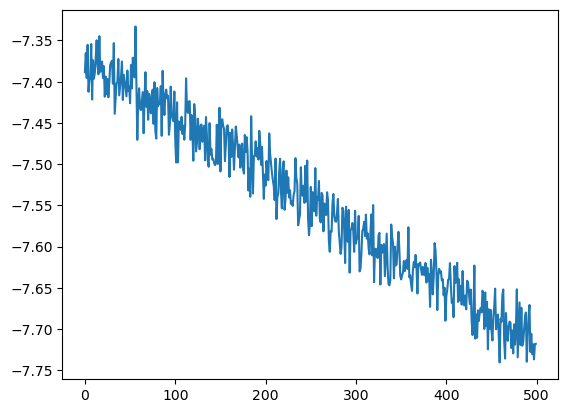

In [65]:
plt.plot(average_loss)

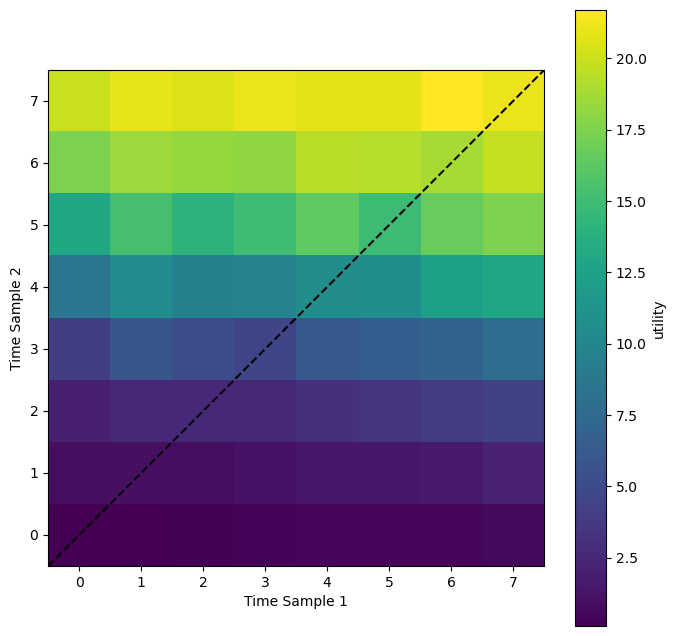

In [66]:
eigs_list = np.array([i.detach().numpy() for i in eigs.values()])
plt.figure(figsize=(8,8))
img_2D = plt.imshow(eigs_list.reshape(p,p), origin="lower")
cbar = plt.colorbar(img_2D)
cbar.set_label("utility")
plt.axline((0,0), slope=1, c='black', linestyle='--')
plt.xlabel("Time Sample 1")
plt.ylabel("Time Sample 2")
plt.show()